In [2]:
%load_ext autoreload
%autoreload 2

#Misc
import time, os, sys, pdb, subprocess
from glob import glob
from fnmatch import fnmatch

#Base
import numpy as np
import pandas as pd
import scipy.stats as st

#Save
import json
import scipy.io as sio
import h5py
import io_dict_to_hdf5 as ioh5

#Plot
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
# cmap = usrplt.gradient_cmap(usrplt.color_palette)
sns.set_style("ticks")

#Model
import ssm

#User
import util
import plotting as usrplt


In [3]:
#Read in cross-validation parameters
BaseDir = './results/sticky-ARHMM_lag-1_dsf-2_kappa-1e+07_2020-11-15_1437'
with open(os.path.join(BaseDir,'ARHMM_hyperparameters.json')) as json_file:
    opt = json.load(json_file)
opt

{'save': 1,
 'mID': 'all_mice',
 'downsample_factor': 2,
 'model_type': 'ARHMM',
 'transitions': 'sticky',
 'observations': 'autoregressive',
 'inputdriven': 0,
 'Kmin': 6,
 'Kmax': 16,
 'kappa': 10000000.0,
 'AR_lags': 1,
 'MAP_threshold': 0.75,
 'EM_tolerance': 1e-06,
 'EM_iters': 200,
 'xval_type': 'K',
 'kXval': 2,
 'max_processes': 15,
 'SaveDirRoot': '/home/dwyrick/projects/jumping_behavior/results/sticky-ARHMM_lag-1_dsf-2_kappa-1e+07_2020-11-15_1437'}

In [52]:
#Read in cluster results from UMAP analysis
with open('./data/hclusters.json') as json_file:
    hclusters = json.load(json_file)
    
with open('./data/Side_windows.json') as json_file:
    Side_windows = json.load(json_file)

In [11]:
##===== Read in data at downsample factor =====##
data_list, mask_list, data_df = util.read_data(dsf=opt['downsample_factor'])

##===== Read in data at downsample factor =====##
data_fullres_list, _, _ = util.read_data(dsf=1)

In [13]:
#Set abort trials to failure trials
data_df.loc[data_df['success'] == 2,'success'] = 0

#Set "opto suture" trials where there was no optogenetics performed to "suture" trials
data_df.loc[(data_df['laser_trial'] == 'laser off') & (data_df['condition'] == 'opto suture'),'condition'] = 'suture'

#Print
data_df.head()

,expdate,subject,condition,platform,distance,success,laser_trial,jump_time,trial,fps,...,Side LEar y,Top LEar y,Side LEar likelihood,Top LEar likelihood,Side TakeFL x,Top TakeFL x,Side TakeFL y,Top TakeFL y,Side TakeFL likelihood,Top TakeFL likelihood
0,061920,J157BLT,control,2,8,0,laser off,125,1,60,...,"[425.385317744935, 366.33104528399747, 307.276...","[410.1932973761308, 352.0100881476151, 293.743...","[0.9999992847442627, 0.9999996423721313, 0.999...","[0.9999997615814209, 0.9999998807907104, 0.999...","[343.8412719726563, 458.4371704101562, 573.033...","[314.5657470703125, 419.42099609375003, 524.27...","[449.0091425115412, 384.95652410333804, 320.90...","[401.4983811248759, 342.47820290221966, 283.45...","[0.999998927116394, 0.9999992847442627, 0.9999...","[0.022194653749465942, 0.013417750597000122, 0..."
1,061920,J157BLT,control,1,20,0,laser off,222,2,60,...,"[433.1472437062976, 376.13851567895387, 319.12...","[410.46880031185265, 353.5964736516964, 296.65...","[0.9999973773956299, 0.9999958276748657, 0.999...","[0.9999992847442627, 0.9999996423721313, 0.999...","[343.52678222656255, 458.06650390625003, 572.6...","[312.7005615234375, 416.93408203125, 521.16760...","[447.5615396573399, 383.70670567296486, 319.85...","[404.90802086255826, 346.7887886848239, 288.66...","[0.9999996423721313, 0.9999996423721313, 0.999...","[0.04482194781303406, 0.06799852848052979, 0.0..."
2,061920,J157BLT,control,3,8,1,laser off,355,3,60,...,"[407.3741518887608, 348.01848782626075, 288.58...","[361.26440623890267, 306.1514179576527, 251.19...","[0.9999998807907104, 0.9999998807907104, 0.999...","[0.9999997615814209, 0.9999997615814209, 0.999...","[343.5391479492188, 457.974072265625, 572.3549...","[314.574169921875, 419.43222656250003, 524.290...","[446.51506847034796, 382.5187916148792, 318.38...","[402.4329915364583, 344.60011800130206, 286.76...","[0.9999998807907104, 0.9999998211860657, 0.999...","[0.8656889796257019, 0.7850416302680969, 0.630..."
3,061920,J157BLT,control,1,12,1,laser off,514,4,60,...,"[426.17190549660387, 369.09125364113515, 311.7...","[375.1970238334944, 319.0105187065413, 262.857...","[0.9999997615814209, 0.9999995231628418, 0.999...","[0.9999972581863403, 0.9999987483024597, 0.999...","[343.9951171875, 458.68979492187503, 573.36568...","[315.40451660156253, 420.53935546875005, 525.6...","[448.9589674068071, 385.0646436763384, 321.142...","[405.64251222127933, 347.9299939107325, 290.21...","[0.9999951720237732, 0.9999984502792358, 0.999...","[0.004946380853652954, 0.004948854446411133, 0..."
4,061920,J157BLT,control,2,12,0,laser off,651,5,60,...,"[429.43573380136877, 369.31512833261877, 308.8...","[354.6358043391531, 299.05050770829365, 243.60...","[1.0, 0.9999998807907104, 0.9999995231628418, ...","[0.9999991655349731, 0.9999986886978149, 0.999...","[343.91730957031257, 458.74045410156253, 573.5...","[313.2942993164063, 417.3133544921875, 521.236...","[446.6510607711668, 382.556981181323, 318.4961...","[403.01506375902665, 345.44733914965167, 287.8...","[0.9999997615814209, 0.9999998807907104, 0.999...","[0.9386019706726074, 0.956940770149231, 0.9827..."


In [41]:
data_df.keys()

Index(['expdate', 'subject', 'condition', 'platform', 'distance', 'success',
       'laser_trial', 'jump_time', 'trial', 'fps', 'Top_pixpercm',
       'Side_pixpercm', 'ocular', 'Side_Start', 'Side_Jump', 'Top_Start',
       'Top_Jump', 'Side Nose x', 'Top Nose x', 'Side Nose y', 'Top Nose y',
       'Side Nose likelihood', 'Top Nose likelihood', 'Side WiskPad x',
       'Top WiskPad x', 'Side WiskPad y', 'Top WiskPad y',
       'Side WiskPad likelihood', 'Top WiskPad likelihood', 'Side LEye x',
       'Top LEye x', 'Side LEye y', 'Top LEye y', 'Side LEye likelihood',
       'Top LEye likelihood', 'Side LEar x', 'Top LEar x', 'Side LEar y',
       'Top LEar y', 'Side LEar likelihood', 'Top LEar likelihood',
       'Side TakeFL x', 'Top TakeFL x', 'Side TakeFL y', 'Top TakeFL y',
       'Side TakeFL likelihood', 'Top TakeFL likelihood'],
      dtype='object')

In [6]:
K = 12
SaveDir = os.path.join(BaseDir,'K-{:0d}'.format(K))
fname_sffx = 'sARHMM_lag-{}_K-{:02d}_dsf-{}_Kappa-{:.0e}'.format(opt['AR_lags'],K,opt['downsample_factor'],opt['kappa'])

#Load MAP sequence results
fpath = glob(os.path.join(SaveDir,'MAP_seqs*.h5'))[0]
trMAPs, trPosteriors, trMasks, arhmm_params, opt = ioh5.load_MAP_seqs_h5(fpath)

/home/dwyrick/projects/jumping_behavior/io_dict_to_hdf5.py:66: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  ans[key] = item.value


In [7]:
# TCMs = util.get_transition_count_matrices(trMAPs,trMasks,K,normalize=False)
# TPM = arhmm.transitions.transition_matrix

## Calculate state duration and state usage 
state_duration_list, state_startend_list, mean_state_durations, state_usage_pertrial, state_usage = util.get_state_durations(trMAPs, trMasks, K)

In [57]:
#For plotting below
color_names_K = usrplt.color_names[:K]; color_names_K.append(usrplt.color_names[-1])
color_palette = sns.xkcd_palette(color_names_K)
cmap = usrplt.gradient_cmap(sns.xkcd_palette(usrplt.color_names[:K]))


In [31]:
#Let's look across mice to start out 
indy_dict = data_df.groupby(['ocular','distance','success']).indices

print('# of trials per condition')
for key in indy_dict.keys():
    print('\t', key,': ', len(indy_dict[key]))

# of trials per condition
	 ('binocular', 8, 0) :  11
	 ('binocular', 8, 1) :  572
	 ('binocular', 12, 0) :  26
	 ('binocular', 12, 1) :  583
	 ('binocular', 16, 0) :  57
	 ('binocular', 16, 1) :  533
	 ('binocular', 20, 0) :  146
	 ('binocular', 20, 1) :  444
	 ('binocular', 24, 0) :  402
	 ('binocular', 24, 1) :  197
	 ('monocular', 8, 0) :  9
	 ('monocular', 8, 1) :  250
	 ('monocular', 12, 0) :  32
	 ('monocular', 12, 1) :  239
	 ('monocular', 16, 0) :  31
	 ('monocular', 16, 1) :  238
	 ('monocular', 20, 0) :  70
	 ('monocular', 20, 1) :  206
	 ('monocular', 24, 0) :  181
	 ('monocular', 24, 1) :  83


In [ ]:
usrplt.plot_state_usage_per_condition(state_usage_pertrial,data_df,SAVEFIG=False)

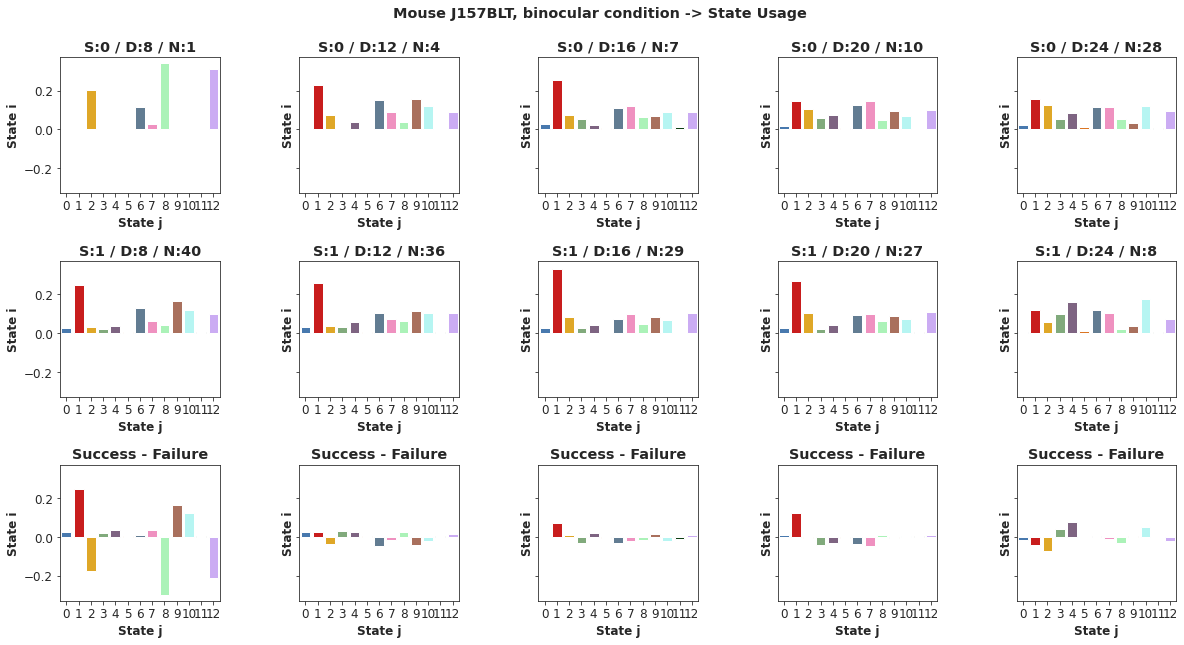

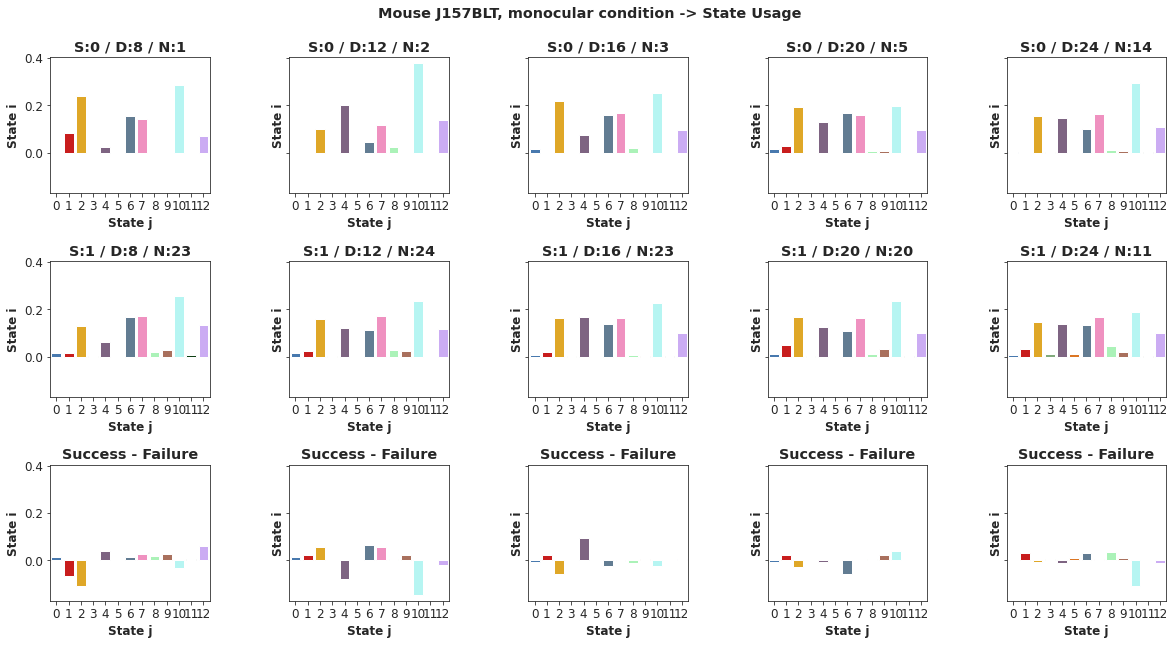

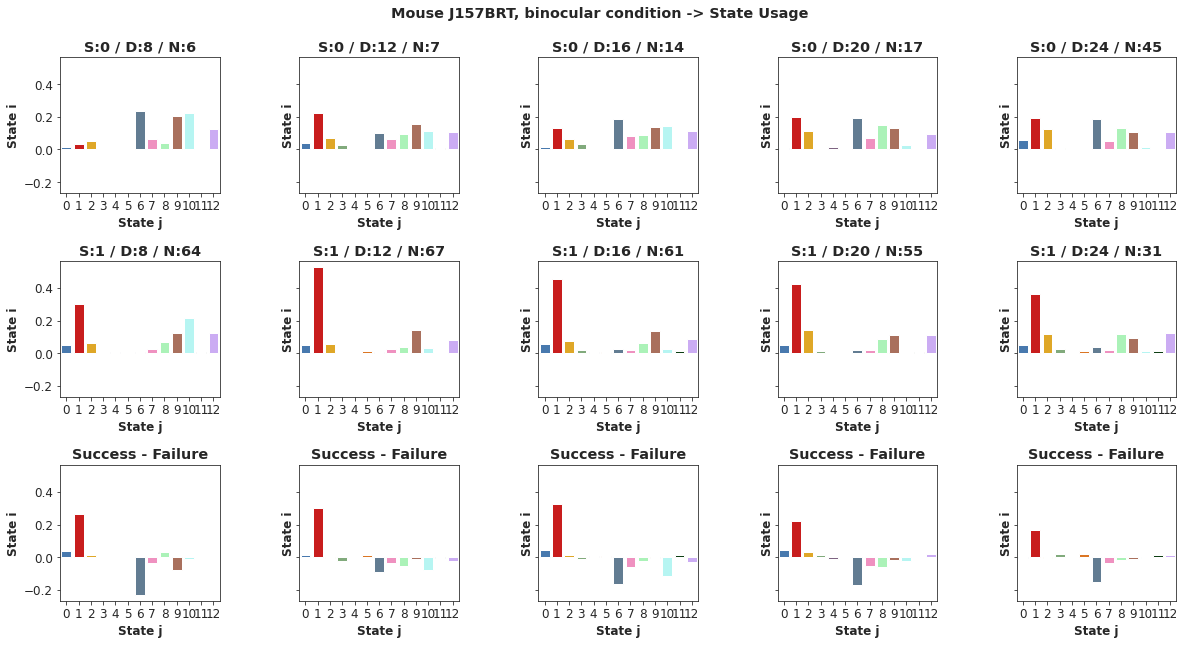

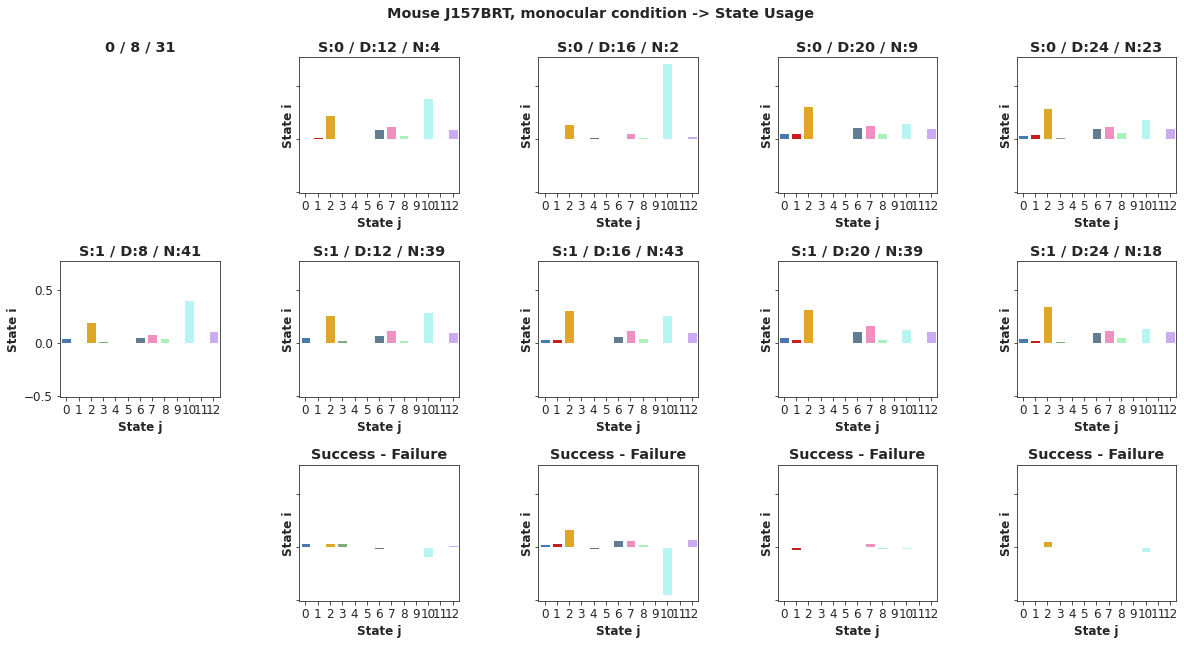

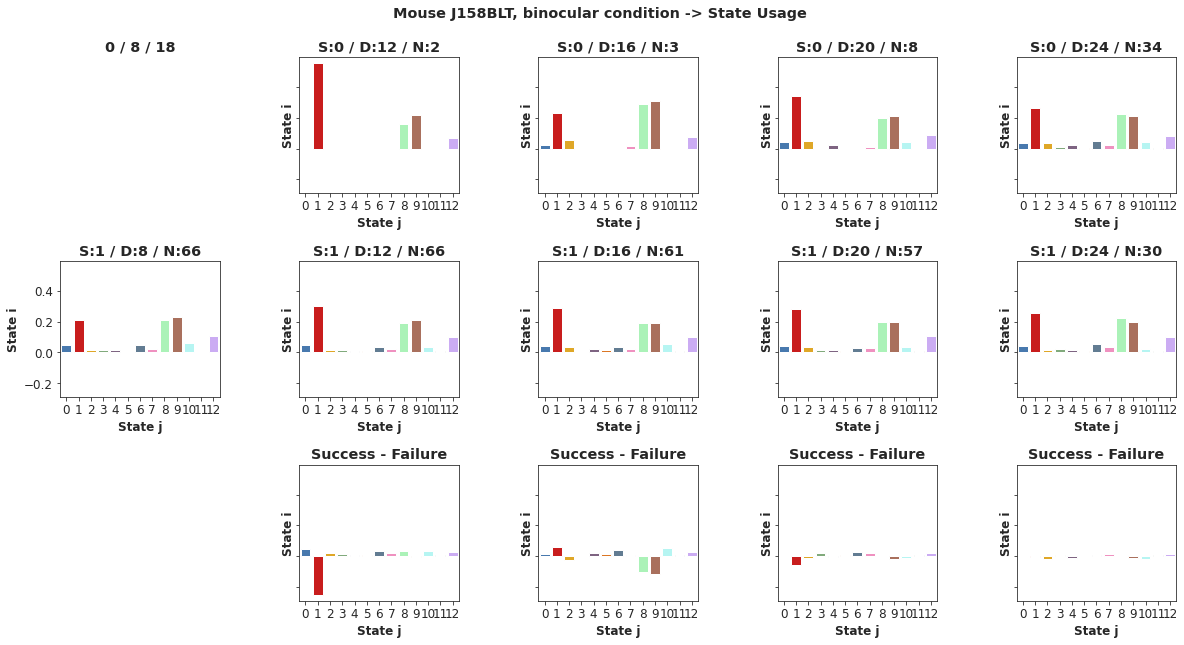

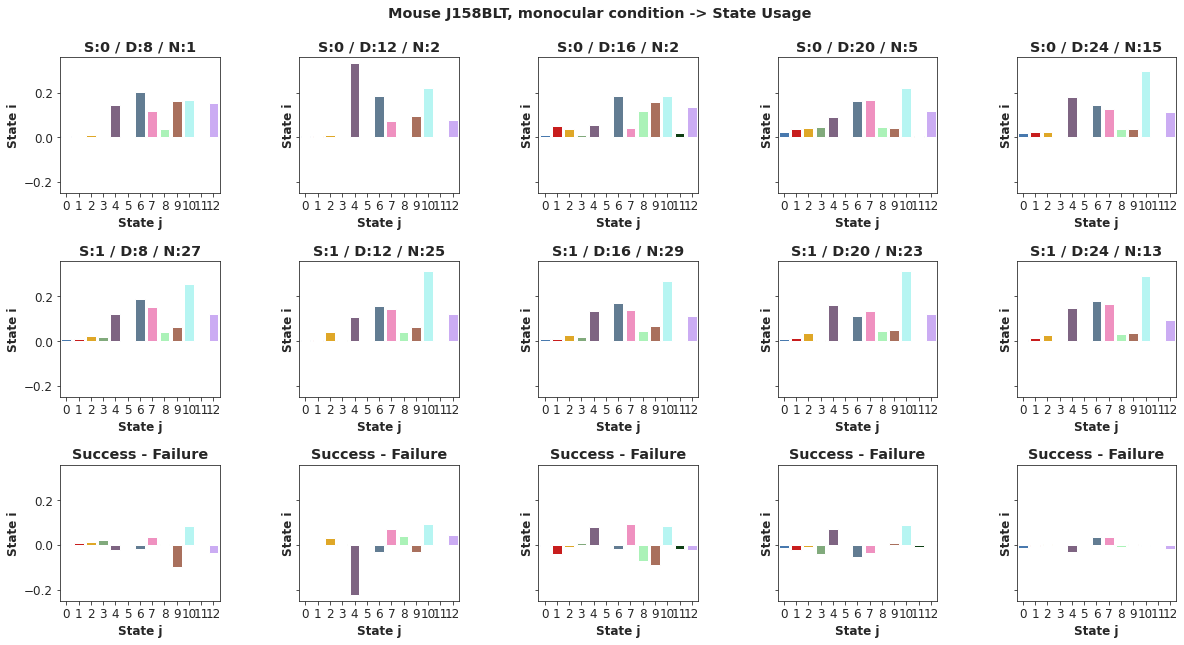

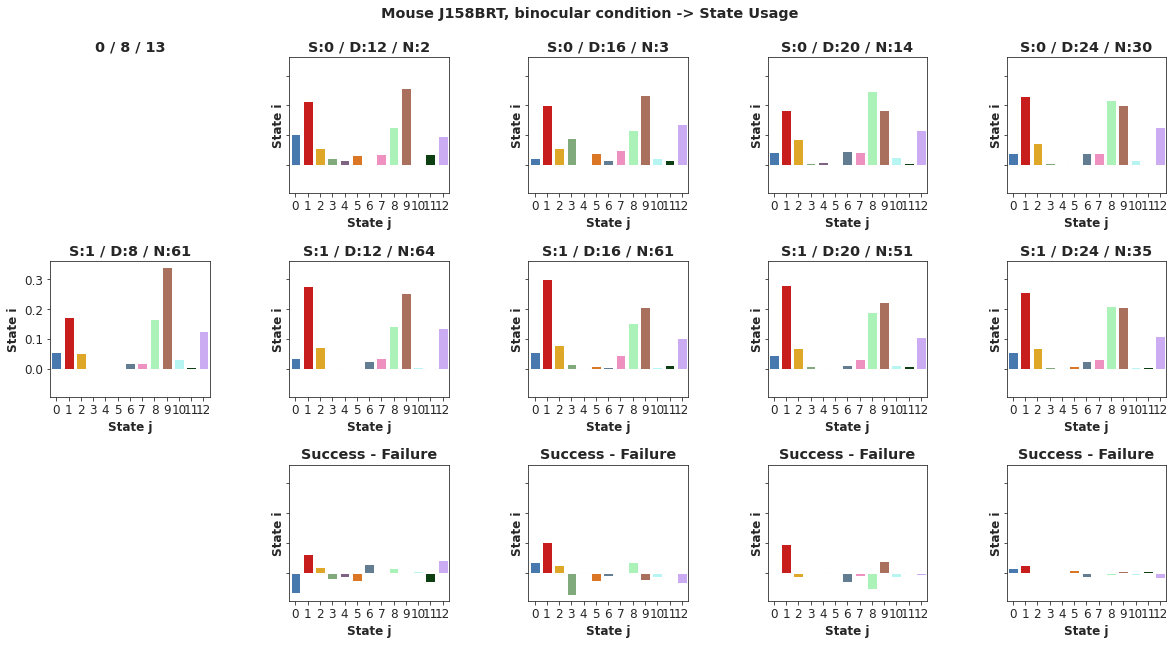

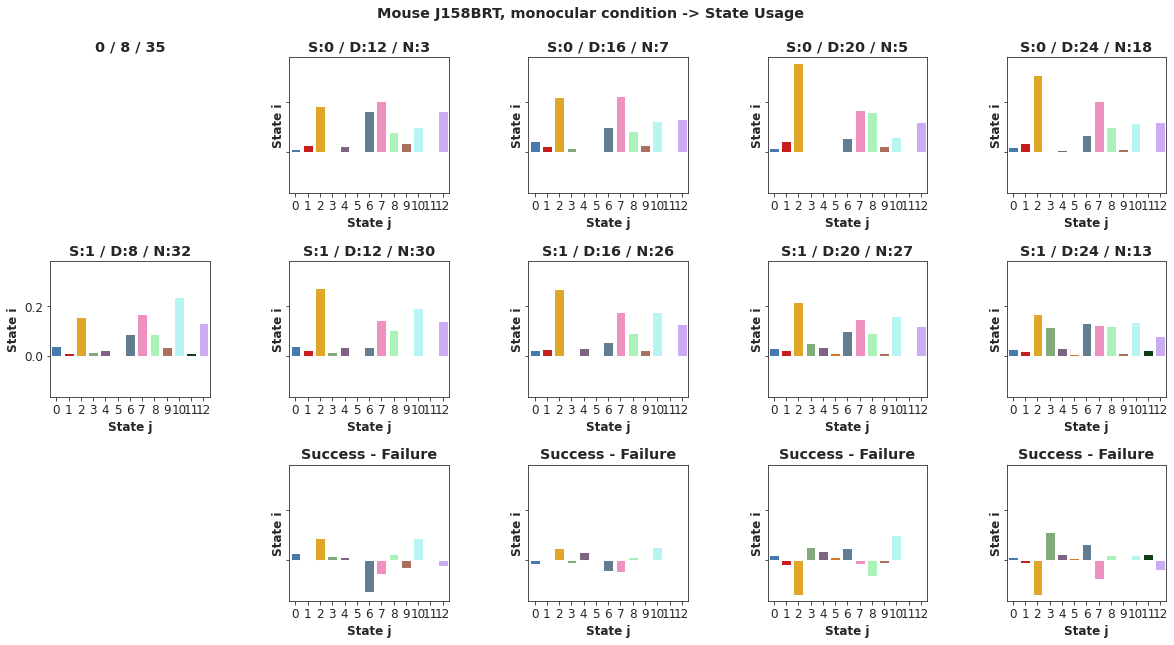

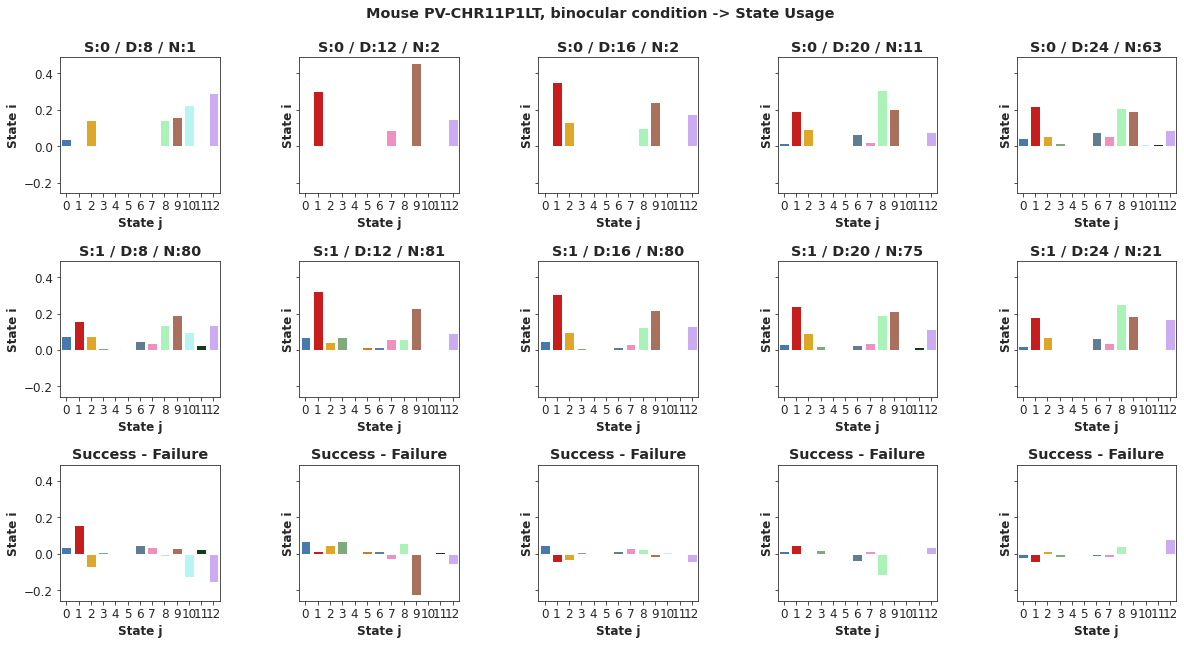

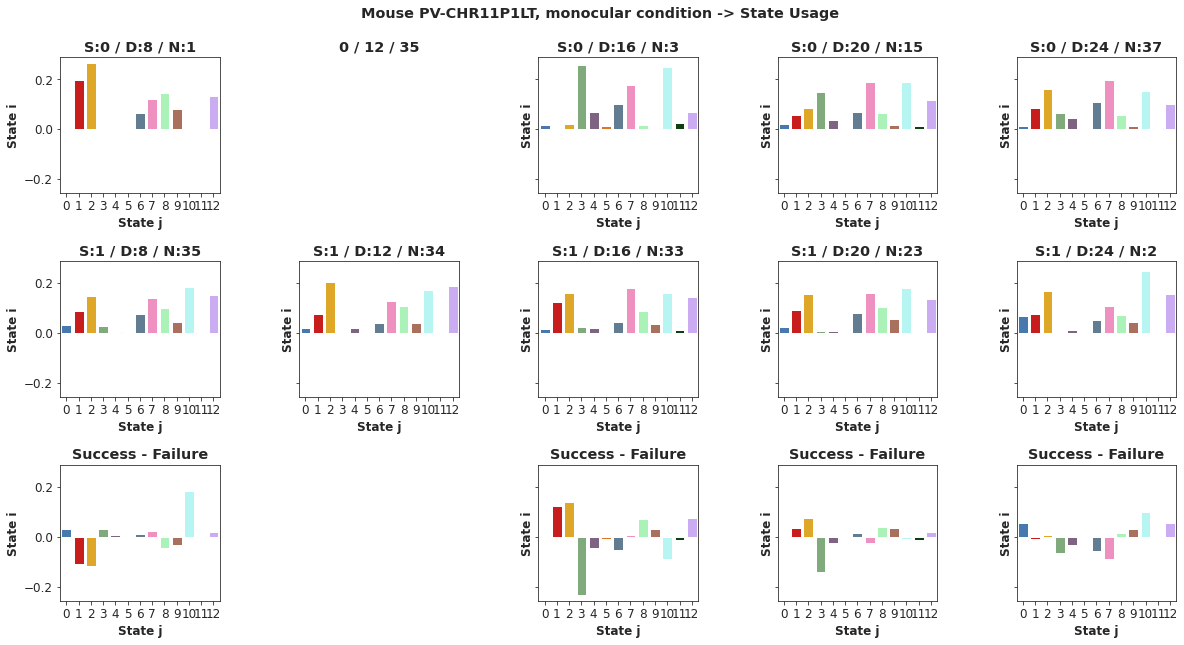

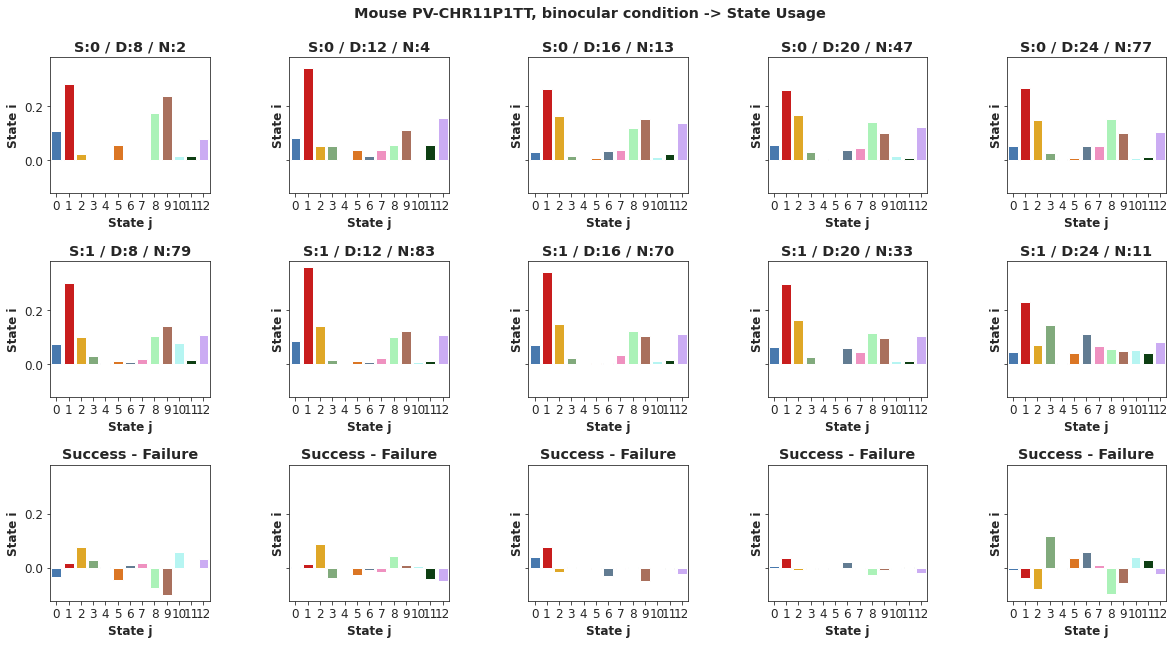

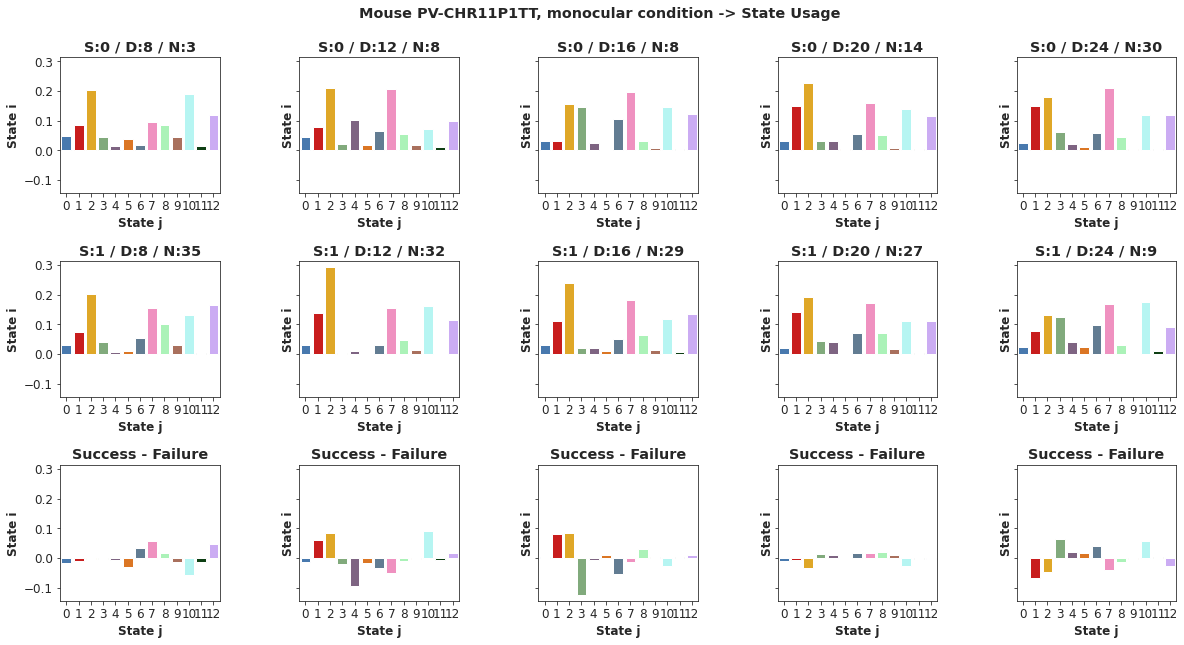

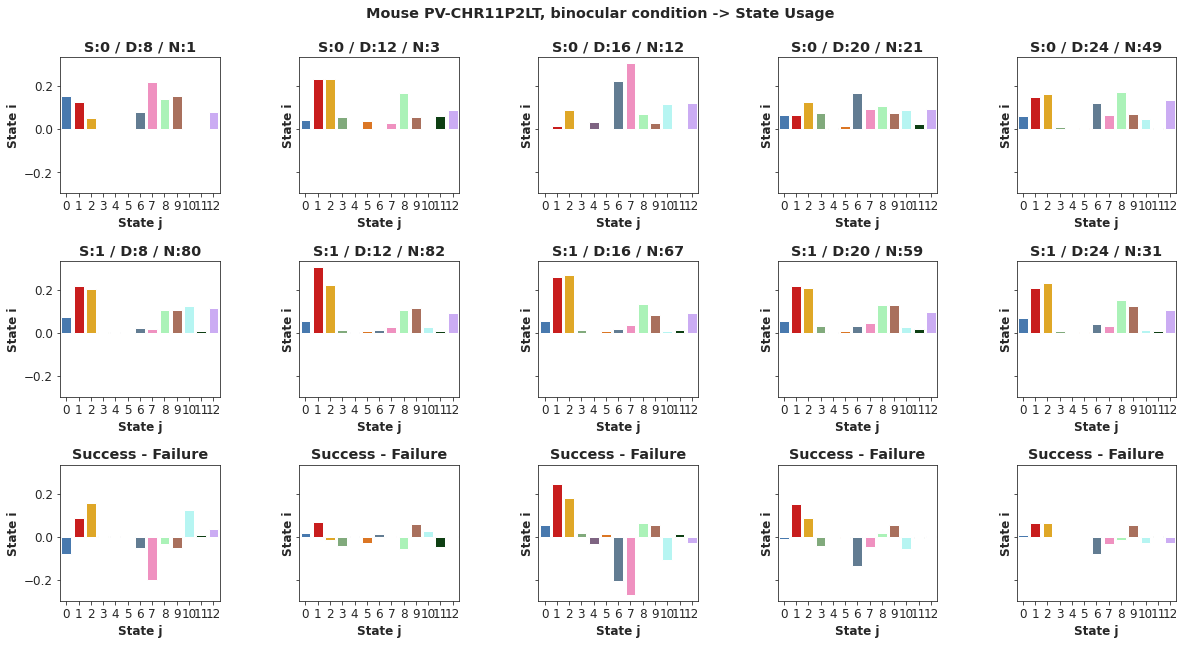

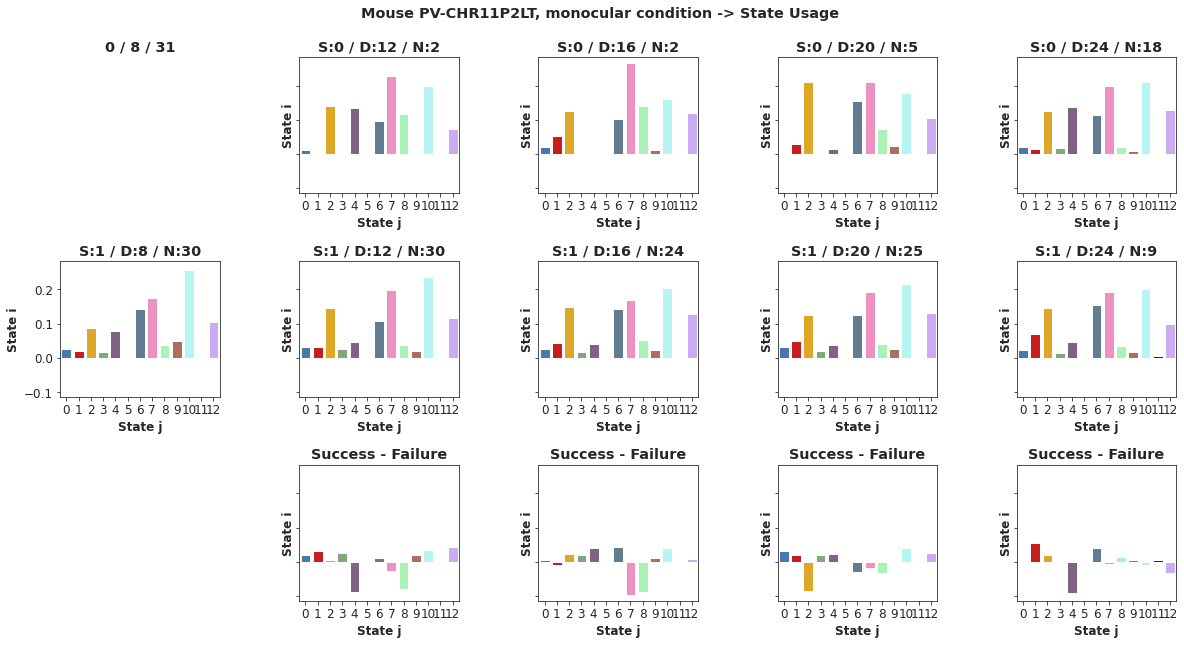

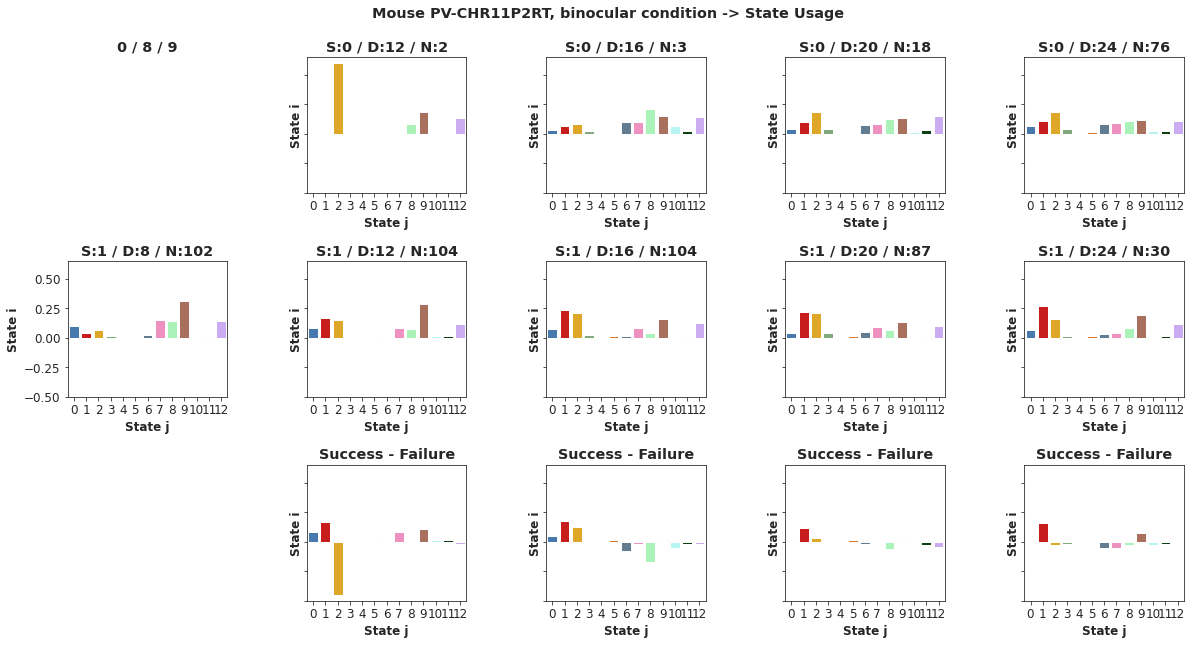

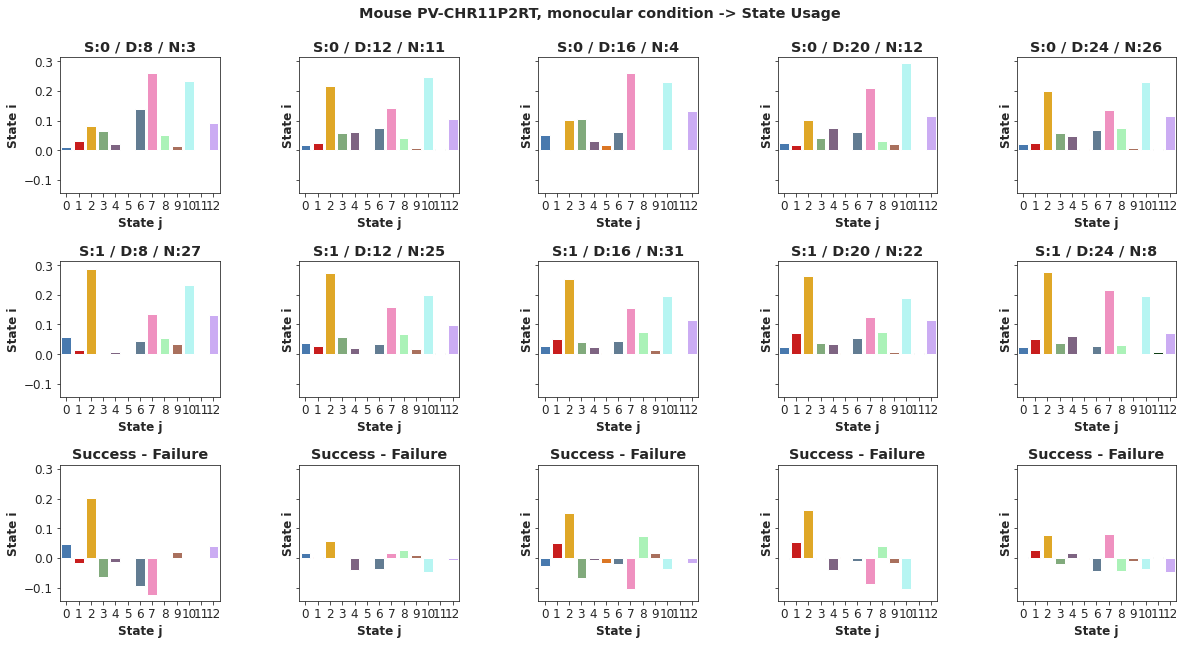

In [93]:
usrplt.plot_state_usage_per_mouse(state_usage_pertrial,data_df,SAVEFIG=False)

In [59]:
nClusters = 12
su_hclustering = np.zeros((nClusters,))
for iTrial,clusters in enumerate(hclusters):
    if len(clusters) == 0:
        continue
    for iC in clusters:
        su_hclustering[iC] += 1
    

<AxesSubplot:>

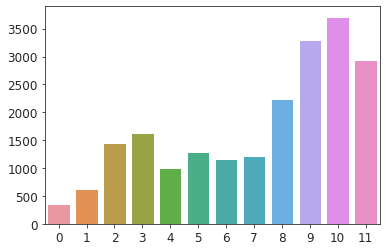

In [61]:
sns.barplot(np.arange(nClusters),su_hclustering)

In [72]:
cnt = 0
for iTrial in range(nTrials):
    if (iC in hclusters[iTrial]):
        cnt +=1
        pdb.set_trace()
        
cnt

> <ipython-input-72-7171be9877e6>(2)<module>()
      1 cnt = 0
----> 2 for iTrial in range(nTrials):
      3     if (iC in hclusters[iTrial]):
      4         cnt +=1
      5         pdb.set_trace()



ipdb>  iTrial


3


ipdb>  hclusters[iTrial]


[1, 0, 0, 8, 5, 9, 10]


ipdb>  (len(hclusters[iTrial]) == 0) or (iC not in hclusters[iTrial])


False


ipdb>  len(hclusters[iTrial]) == 0


False


ipdb>  iC not in hclusters[iTrial]


False


ipdb>  iC in hclusters[iTrial]


True


ipdb>  q


BdbQuit: 

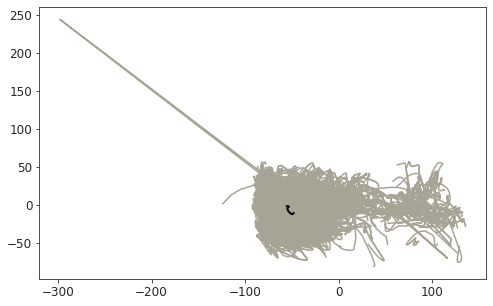

In [89]:
nClusters = 12
nTrials = len(data_list)
# for iC in range(nClusters):
iC = 10

traces = []
fig, ax = plt.subplots(figsize = (8,5))
for iTrial in range(nTrials):
    if (len(hclusters[iTrial]) == 0) or (iC not in hclusters[iTrial]):
        continue

    indy = np.where(np.array(hclusters[iTrial]) == iC)[0]
    data = data_fullres_list[iTrial]
    for ii in indy:
        tStart = Side_windows[iTrial][ii]
        tSlice = slice(tStart,tStart+89)
        ax.plot(data[tSlice,0],data[tSlice,1],'-',color=usrplt.cc[-1])
        traces.append(data[tSlice,:])
        
ax.plot(np.mean(traces,axis=0)[:,0],np.mean(traces,axis=0)[:,1],'-k',lw=2)

    
        
    
        
    
            
        
            
        
        
    

In [85]:
np.mean(traces,axis=0).shape

ValueError: operands could not be broadcast together with shapes (90,6) (89,6) 

In [81]:
np.array(traces).shape

(359, 90, 6)